# Exploring the Satellogic EarthView STAC via GeoParquet

This notebook demonstrates how to use `duckdb`, `h3`, `geopandas`, `lonboard` to explore the STAC GeoParquet version of the Satellogic EarthView STAC hosted in AWS S3 at:

`s3://satellogic-earthview-stac-geoparquet/satellogic-earthview-stac-items.parquet`

While you can download this file by clicking [here](https://satellogic-earthview-stac-geoparquet.s3.us-west-2.amazonaws.com/satellogic-earthview-stac-items.parquet), Parquet is a cloud-friendly format so it can be efficiently accessed directly in object storage.

First up, some imports...

In [ ]:
import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pystac

from lonboard import Map, PolygonLayer, viz
from lonboard.colormap import apply_continuous_cmap
from lonboard import basemap
from matplotlib import colors

Install the `spatial` and `h3` extensions for `duckdb`:

In [218]:
# create a connection which we'll reuse throughout

con = duckdb.connect()

for ext in ["spatial", "h3"]:
    duckdb.install_extension(ext)
    con.load_extension(ext)


con.sql(f"SELECT extension_name, installed from duckdb_extensions() WHERE extension_name IN ('spatial', 'h3')")

┌────────────────┬───────────┐
│ extension_name │ installed │
│    varchar     │  boolean  │
├────────────────┼───────────┤
│ spatial        │ true      │
│ h3             │ true      │
└────────────────┴───────────┘

Define a variable with the URI of the Parquet file:

In [71]:
earthview_stac_uri = "s3://satellogic-earthview-stac-geoparquet/satellogic-earthview-stac-items.parquet"

Now we can start using `duckdb` to query the Parquet file in place using SQL-like dialect. 

Let's start by checking that the dataset contains around 7 million rows (STAC Items):

In [429]:
con.sql(f"SELECT COUNT(*) items FROM '{earthview_stac_uri}'")

┌─────────┐
│  items  │
│  int64  │
├─────────┤
│ 7095985 │
└─────────┘

Great! How is the data organized?

In [364]:
con.sql(f"DESCRIBE SELECT * FROM '{earthview_stac_uri}'").show(max_width=100, max_rows=24)

┌─────────────────────┬────────────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│     column_name     │            column_type             │  null   │   key   │ default │  extra  │
│       varchar       │              varchar               │ varchar │ varchar │ varchar │ varchar │
├─────────────────────┼────────────────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ assets              │ STRUCT(analytic STRUCT("eo:bands…  │ YES     │ NULL    │ NULL    │ NULL    │
│ bbox                │ STRUCT(xmin DOUBLE, ymin DOUBLE,…  │ YES     │ NULL    │ NULL    │ NULL    │
│ geometry            │ GEOMETRY                           │ YES     │ NULL    │ NULL    │ NULL    │
│ id                  │ VARCHAR                            │ YES     │ NULL    │ NULL    │ NULL    │
│ links               │ STRUCT(href VARCHAR, rel VARCHAR…  │ YES     │ NULL    │ NULL    │ NULL    │
│ stac_extensions     │ VARCHAR[]                          │ YES     │ NULL    │ NULL    │ 

Each column represents a key on the source STAC Items, with the `properties` unnested to the top-level. We can compare against a source Item by querying for the `self` link and loading it with `pystac`:

In [255]:
pystac.Item.from_file(con.sql(f"SELECT links::JSON -> 2 -> 'href' FROM '{earthview_stac_uri}' LIMIT 1").fetchone()[0].replace('"', ""))

<Item id=20220701_142509_SN23_21S_667983_6954390>

We can use these fields in queries to aggregate the data. For example, we can use the `datetime` and `platform` fields to calculate the count of observations per satellite (`platform`) per month:

In [430]:
con.sql(f"""
WITH a AS (
    SELECT   platform,
             monthname(datetime) month_,
             ROUND(COUNT(*))::INT num_rec
    FROM '{earthview_stac_uri}'
    GROUP BY 1, 2
    ORDER BY 1, 2
)
PIVOT    a
ON       month_
USING    SUM(num_rec)
GROUP BY platform
ORDER BY regexp_extract(platform, '\d+')::INT;
"""
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────┬────────┬──────────┬────────┬──────────┬─────────┬───────────┐
│ platform │ August │ December │  July  │ November │ October │ September │
│ varchar  │ int128 │  int128  │ int128 │  int128  │ int128  │  int128   │
├──────────┼────────┼──────────┼────────┼──────────┼─────────┼───────────┤
│ newsat8  │   NULL │     NULL │   3151 │     NULL │    NULL │      NULL │
│ newsat9  │  66282 │    58427 │  54026 │    99821 │   65069 │     71407 │
│ newsat11 │  51885 │    75379 │  54600 │    81729 │   50774 │     83082 │
│ newsat12 │   NULL │     NULL │   NULL │     NULL │    NULL │      1244 │
│ newsat13 │  14686 │    39772 │  65751 │    14303 │    NULL │      NULL │
│ newsat14 │   NULL │      630 │   NULL │     NULL │    4318 │      6659 │
│ newsat15 │  51628 │     NULL │  86204 │    47174 │   87395 │     94706 │
│ newsat16 │  53048 │    95607 │  71389 │    65613 │   73353 │     37301 │
│ newsat18 │  74808 │   152027 │  79529 │   118417 │   64653 │     60351 │
│ newsat20 │  70856 │    

The Satellogic dataset is a gridded product and the tile ID for each image is defined by the `grid:code` [STAC property](https://github.com/stac-extensions/grid).

We can count the distinct tile identifiers to determine how many unique tiles the dataset covers:

In [366]:
con.sql(f"""
SELECT COUNT(DISTINCT "grid:code") count
FROM '{earthview_stac_uri}'
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┐
│  count  │
│  int64  │
├─────────┤
│ 2967002 │
└─────────┘

There are nearly 3 million unique grid tiles represented in the ~7 million images.

What does the frequency distribution of the observations per tile look like?

In [431]:
tile_obs_df = con.sql(f"""
SELECT n_obs, COUNT(*) AS n_tiles
FROM (
    SELECT "grid:code" grid_code, COUNT(*) AS n_obs
    FROM '{earthview_stac_uri}'
    GROUP BY grid_code
) sub
GROUP BY n_obs
ORDER BY n_obs DESC;
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Text(0.5, 0, '# observations')

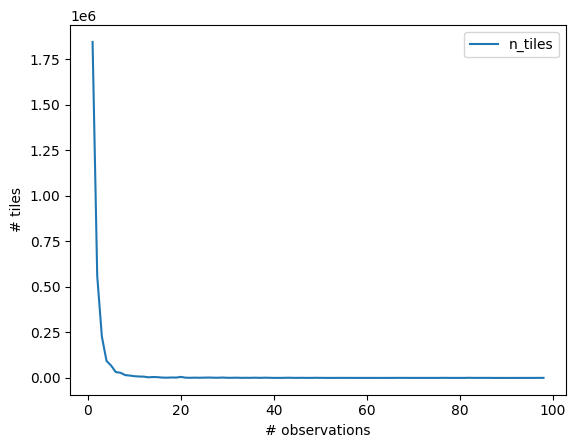

In [373]:
ax = tile_obs_df.plot(y='n_tiles', x='n_obs')
ax.set_ylabel("# tiles")
ax.set_xlabel("# observations")

Most tiles have only a handful of observations, while a few tiles have 10 to 100 observations.

We can also plot the count of all observations over time.

<Axes: xlabel='date'>

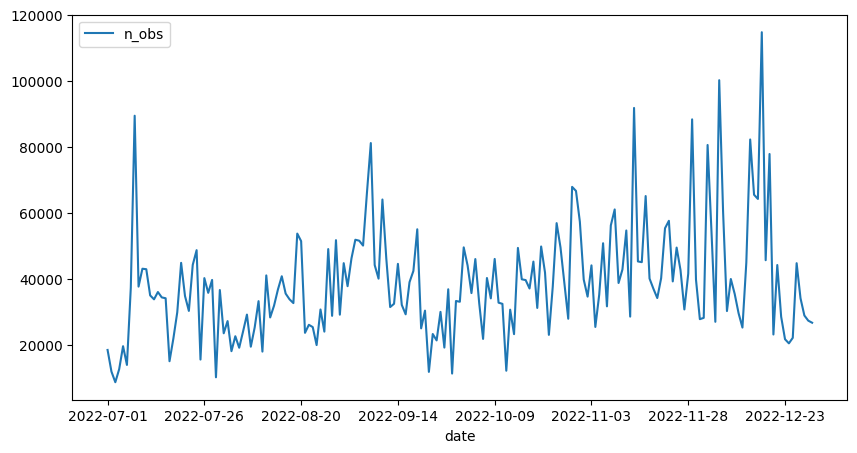

In [308]:
obs_date_df = con.sql(f"""
SELECT date, COUNT(*) n_obs
FROM (
    SELECT STRFTIME(datetime, '%Y-%m-%d') date
    FROM '{earthview_stac_uri}'
)
GROUP BY date
ORDER BY date ASC
""").df()

obs_date_df.set_index('date', inplace=True)
obs_date_df.plot(figsize=(10, 5))

Out of curiosity, let's take a peek at the observation frequency for a couple of grid tiles.

In [450]:
tile_revisit_df = con.sql(f"""
SELECT datetime, "grid:code" grid_code
FROM '{earthview_stac_uri}'
WHERE grid_code in ('12N-508710_3081633', '46N-371411_2453246')
""").df()

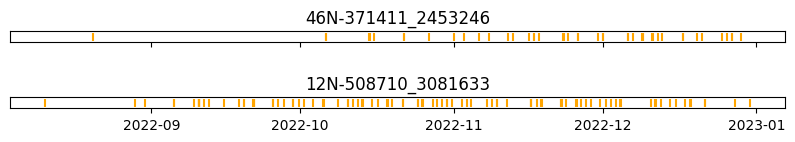

In [451]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 1), sharex=True)
for i, (ax, tile) in enumerate(zip((ax1, ax2), tile_revisit_df["grid_code"].unique())):
    ax.scatter(
        x=tile_revisit_df[tile_revisit_df["grid_code"] == tile]["datetime"],
        y=[i for _ in range(len(tile_revisit_df[tile_revisit_df["grid_code"] == tile]))],
        marker="|",
        color="orange",
    )
    ax.get_yaxis().set_visible(False)
    ax.set_title(tile)
plt.subplots_adjust(hspace=5)

## Visualizing Observation Frequency with H3 and `lonboard`

How are these images distributed spatially? How many images are available over a given area? Visualizing the footprint all 7 million Items would be a bit overwhelming (but _is_ possible as we'll see later) so let's start by aggregating the observations to the [H3](https://h3geo.org/) hexagonal grid and use a colormap to indicate observation counts.

First, we'll use the `h3` extension for `duckdb` to aggregate image footprints within H3 cells at resolution 5 and count the number of observations:

In [174]:
resolution = 5

h3_df = duckdb.sql(f"""
SELECT h3_latlng_to_cell(
        ST_Y(ST_Centroid(geometry)),
        ST_X(ST_Centroid(geometry)),
        {resolution}
    ) h3_cell_id,
    h3_cell_to_boundary_wkt(h3_cell) geometry,
    COUNT(*) n_obs
FROM '{earthview_stac_uri}'
GROUP BY 1
""").df()

h3_gdf = gpd.GeoDataFrame(h3_df, geometry=gpd.GeoSeries.from_wkt(h3_df["geometry"]), crs="EPSG:4326")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

The cell above converts the `duckdb` query result to a GeoPandas `GeoDataFrame` to simplify styling and conversion to GeoJSON.

Each row in the dataframe represents an `h3` cell and contains the cell's `geometry` and number of observations (`n_obs`):

In [176]:
h3_gdf.head()

,h3_cell,geometry,n_obs
0,599989316516577279,"POLYGON ((0.84827 41.84117, 0.76034 41.78695, ...",5539
1,599989274640646143,"POLYGON ((0.70653 41.55371, 0.61895 41.49917, ...",477
2,599693824914096127,"POLYGON ((-119.06889 40.79818, -119.01099 40.8...",7728
3,600120257184530431,"POLYGON ((104.02144 30.6541, 103.99721 30.7372...",266
4,600120305502912511,"POLYGON ((104.1967 30.6808, 104.17255 30.76395...",321


We can easily check that the `geometry` column contains hexagons:

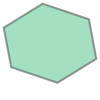

In [177]:
h3_gdf.iloc[0].geometry

How does the distribution of the aggregated observations look? This will inform how we style the hexagons.

Text(0.5, 1.0, 'log(n_obs)')

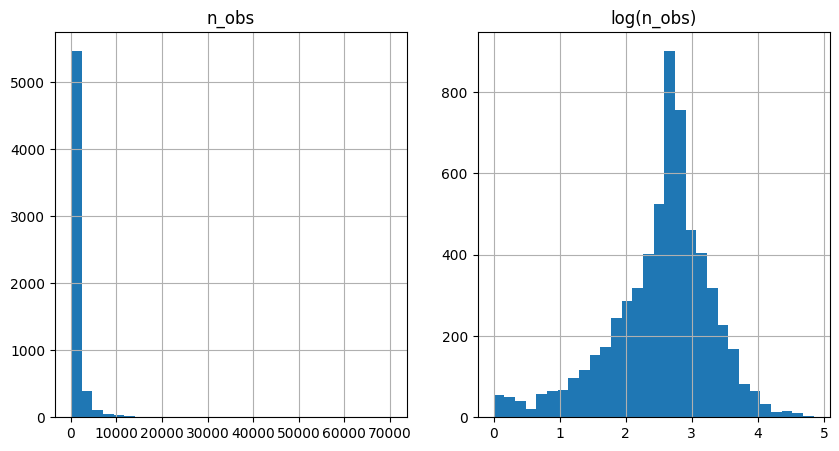

In [266]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

bins = 30

h3_gdf["n_obs"].hist(bins=bins, ax=ax1)
ax1.set_title("n_obs")

np.log10(h3_gdf["n_obs"]).hist(bins=bins, ax=ax2)
ax2.set_title("log(n_obs)")

In [178]:
h3_gdf["n_obs"].describe()

count     6124.000000
mean      1158.717342
std       3051.293650
min          1.000000
25%        141.750000
50%        468.000000
75%       1016.250000
max      70305.000000
Name: n_obs, dtype: float64

Looks like most hexagons represent a couple hundred to a couple thousand observations with a handful representing 10s of thousands of observations so we can apply a log transformed colormap using `matplotlib`'s `LogNorm` (h/t to [the `lonboard` docs](https://developmentseed.org/lonboard/latest/examples/overture-maps/#imports:~:text=Building%20heights%20tend%20to%20scale%20non%2Dlinearly.%20That%20is%2C%20the%20vast%20majority%20of%20buildings%20are%20relatively%20low%2C%20but%20a%20few%20buildings%20are%20very%20tall.%20So%20that%20the%20low%20buildings%20aren%27t%20completely%20washed%20out%2C%20we%27ll%20use%20matplotlib%27s%20LogNorm%20to%20normalize%20these%20values%20according%20to%20a%20log%20scale)). I'm using [`lonboard`](https://developmentseed.org/lonboard/latest/) to display this aggregated data on an interactive slippy map. While this dataset is fairly small, we'll use `lonboard`'s ability to efficiently display large datasets later on when we visualize all 7M+ image footprints.

In [ ]:
# create normalizer
normalizer = colors.LogNorm(
    vmin=1,
    vmax=h3_gdf["n_obs"].quantile(0.95),
    clip=True
)

# log transform n_obs
normalized_nobs = normalizer(h3_gdf["n_obs"])

# get a nice perceptually uniform colormap from matplotlib
colormap = plt.colormaps.get("plasma")

# create a lonboard PolygonLayer
h3_layer = PolygonLayer.from_geopandas(
    gdf=h3_gdf,
    get_line_width=2,
    get_fill_color=apply_continuous_cmap(
        normalized_nobs,
        colormap
    ),
    get_line_color=[0, 0, 0],  # black
)

# create and display a Map with the layer
m = Map(h3_layer, basemap_style=basemap.CartoBasemap.DarkMatter, _height=800)
m

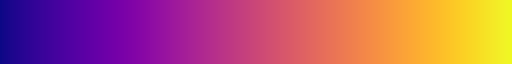

In [267]:
colormap

While we're at it, we can export this to a stylized GeoJSON file that can be loaded by [geojson.io](https://geojson.io/#data=data:text/x-url,https%3A%2F%2Fraw.githubusercontent.com%2Fbmcandr%2Fsatellogic-earthview-stac-parquet%2Frefs%2Fheads%2Fmain%2Fdata%2Fsatellogic_earthview_h3_n_obs.geojson).

In [139]:
def create_stylized_geojson(
    gdf: gpd.GeoDataFrame,
    outfile: str,
    colormap: colors.Colormap = plt.colormaps.get("plasma"),
):
    _gdf = gdf.copy()

    _gdf["stroke"] = "#000000"
    _gdf["stroke-width"] = 0.1
    _gdf["fill-opacity"] = 1
    
    _gdf["fill"] = _gdf["n_obs"].apply(lambda x: colors.rgb2hex(colormap(normalizer(x))))
    
    _gdf.to_file(outfile)

create_stylized_geojson(h3_gdf, "satellogic_earthview_h3_n_obs.geojson")

## Visualizing All Unique Grid Tiles

We can use `lonboard` to visualize the footprints of all 3 million unique grid tiles. This will take a minute or two to load. Once the map appears, zoome in to reveal the tile footprints.

In [453]:
result = con.sql(f"""
SELECT "grid:code" grid_code, ANY_VALUE(geometry) geometry, COUNT("grid:code") n_obs
FROM '{earthview_stac_uri}'
GROUP BY grid_code
""")

viz(result, con=con, map_kwargs=dict(_height=800))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

## Visualizing All 7.1 Million Image Footprints

Image footprints overlap so this isn't a particularly informative visualization in and of itself, but it's neat that we can do it. In order to make visualizing all of these geometries, the `lonboard` docs recommend [removing extraneous columns](https://developmentseed.org/lonboard/latest/performance/#remove-columns-before-rendering) and only render relevant columns.

In [454]:
result = con.sql(f"""
SELECT id, "grid:code" grid_code, geometry, platform
FROM '{earthview_stac_uri}'
""")

viz(result, con=con, map_kwargs=dict(_height=800))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

In [452]:
result = con.sql(f"""
SELECT *
FROM '{earthview_stac_uri}'
""")

viz(result, con=con, map_kwargs=dict(_height=800))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

thread '<unnamed>' panicked at /Users/runner/.cargo/registry/src/index.crates.io-6f17d22bba15001f/arrow-data-53.1.0/src/transform/utils.rs:42:56:
offset overflow
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: offset overflow